In [1]:
#!pip install folium --upgrade
#!pip install matplotlib
#!pip install colour

In [1]:
import pandas as pd
import numpy as np
import urllib.request, json
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import folium
from folium.plugins import TimeSliderChoropleth
import geopandas as gp
from datetime import datetime
from colour import Color

In [2]:
print(folium.__version__)

0.11.0


## Primero vamos a trabajar la data del ministerio...

Este producto trae lso casos confirmados por comuna a través dle tiempo:

In [54]:
#Nota mental: siempre importar los Raw de GitHub, perdí demasiado tiempo dandome cuenta de algo tan tonto...

df = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",header=0)
df.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,...,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13,Tasa
0,Arica y Parinacota,15,Arica,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,...,1046.0,1176.0,1371.0,1533.0,1758.0,1887.0,2139.0,2464.0,2721.0,1099.2
1,Arica y Parinacota,15,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,648.8
2,Arica y Parinacota,15,General Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,9.0,10.0,11.0,11.0,11.0,26.0,28.0,1113.3
4,Arica y Parinacota,15,Desconocido Arica y Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,1.0,3.0,1.0,3.0,3.0,3.0,NaN


In [55]:
df.shape

(362, 39)

In [56]:
df.Region.unique()

array(['Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama',
       'Coquimbo', 'Valparaíso', 'Metropolitana', 'O’Higgins', 'Maule',
       'Ñuble', 'Biobío', 'Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén',
       'Magallanes'], dtype=object)

In [57]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    s = s.replace(" ", "_")
    return s

In [58]:
df['Comuna'] = df['Comuna'].apply(lambda x: elimina_tildes(x))

In [59]:
#df_metro = df[df['Region'] == 'Metropolitana'].copy()
df_metro = df.copy()
df_metro.drop(columns={'Region', 'Codigo region', 'Tasa'}, inplace=True)
df_metro.head()

,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,2020-04-10,2020-04-13,...,2020-06-08,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,2020-07-10,2020-07-13
0,Arica,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,87.0,115.0,...,904.0,1046.0,1176.0,1371.0,1533.0,1758.0,1887.0,2139.0,2464.0,2721.0
1,Camarones,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,General_Lagos,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Putre,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,9.0,10.0,11.0,11.0,11.0,26.0,28.0
4,Desconocido_Arica_y_Parinacota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,1.0,3.0,1.0,3.0,3.0,3.0


In [60]:
df_id_comunas = df_metro[['Comuna', 'Codigo comuna']].copy()
df_id_comunas.dropna(inplace=True)
df_id_comunas['Codigo comuna'] = df_id_comunas['Codigo comuna'].astype(int)
df_id_comunas.head()

,Comuna,Codigo comuna
0,Arica,15101
1,Camarones,15102
2,General_Lagos,15202
3,Putre,15201
5,Alto_Hospicio,1107


In [61]:
#Viva le función melt, viva... Sirve para "Despivotear" DataFrames
unpivoted = df_metro.melt(id_vars=['Comuna', 'Codigo comuna', 'Poblacion'], var_name='fecha', value_name='Contagiados')
unpivoted

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados
0,Arica,15101.0,247552.0,2020-03-30,6.0
1,Camarones,15102.0,1233.0,2020-03-30,0.0
2,General_Lagos,15202.0,810.0,2020-03-30,0.0
3,Putre,15201.0,2515.0,2020-03-30,0.0
4,Desconocido_Arica_y_Parinacota,NaN,NaN,2020-03-30,NaN
...,...,...,...,...,...
11941,Rio_Verde,12103.0,211.0,2020-07-13,0.0
11942,San_Gregorio,12104.0,681.0,2020-07-13,2.0
11943,Timaukel,12303.0,282.0,2020-07-13,0.0
11944,Torres_del_Paine,12402.0,1021.0,2020-07-13,0.0


In [62]:
fechas = unpivoted.fecha.unique()
comunas = unpivoted.Comuna.unique()

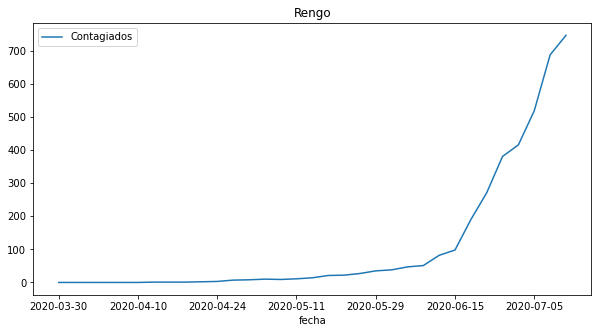

In [105]:
Comuna = np.random.choice(comunas, 1, replace=False)[0]
sample = unpivoted[unpivoted['Comuna'] == Comuna]
sample.plot(x='fecha', y='Contagiados', title=Comuna, figsize=(10,5))

In [64]:
pivoted = unpivoted.pivot(index='fecha' , columns = 'Comuna', values='Contagiados').reset_index()
pivoted.dropna(inplace=True, axis='columns')
pivoted.head()

Comuna,fecha,Algarrobo,Alhue,Alto_Biobio,Alto_Hospicio,Alto_del_Carmen,Ancud,Andacollo,Angol,Antartica,...,Vicuna,Vilcun,Villa_Alegre,Villa_Alemana,Vina_del_Mar,Vitacura,Yerbas_Buenas,Yumbel,Yungay,Zapallar
0,2020-03-30,7.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,4.0,0.0,6.0,29.0,83.0,0.0,5.0,0.0,0.0
1,2020-04-01,7.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,...,0.0,5.0,0.0,8.0,38.0,90.0,0.0,5.0,7.0,0.0
2,2020-04-03,9.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,...,0.0,11.0,0.0,11.0,47.0,100.0,0.0,5.0,10.0,0.0
3,2020-04-06,9.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0,0.0,...,0.0,18.0,0.0,11.0,53.0,114.0,0.0,5.0,26.0,0.0
4,2020-04-08,8.0,0.0,0.0,6.0,0.0,0.0,0.0,23.0,0.0,...,0.0,20.0,0.0,12.0,66.0,114.0,0.0,5.0,37.0,0.0


In [109]:
#pivoted.plot(figsize=(30,10))

## Ahora comenzamos con la parte del mapa...

In [66]:
#!wget https://www.bcn.cl/siit/obtienearchivo?id=repositorio/10221/10396/1/division_comunal.zip
#!mv obtienearchivo\?id\=repositorio%2F10221%2F10396%2F1%2Fdivision_comunal.zip comunal.zip
#!unzip comunal
#!pip install geopandas

df_geo = gp.read_file('Geo Info/division_comunal.shp')
#df.NOM_REG.unique()

In [16]:
df_geo.NOM_REG.unique()

array(['Región de La Araucanía', 'Región de Los Lagos',
       'Región de Los Ríos', 'Región de Aysén del Gral.Ibañez del Campo',
       'Región de Antofagasta', 'Región de Atacama',
       "Región del Libertador Bernardo O'Higgins", 'Región de Coquimbo',
       'Región de Valparaíso', 'Región del Bío-Bío', 'Región del Maule',
       'Región Metropolitana de Santiago',
       'Región de Magallanes y Antártica Chilena', 'Zona sin demarcar',
       'Región de Arica y Parinacota', 'Región de Tarapacá'], dtype=object)

In [77]:
#rmdf = df_geo[df_geo.NOM_PROV=='Santiago'].copy()
rmdf = df_geo.copy()
rmdf['NOM_COM'] = rmdf['NOM_COM'].apply(lambda x: elimina_tildes(x))
rmdf = rmdf.merge(df_id_comunas, left_on='NOM_COM', right_on='Comuna')
print('Procesamos %d comunas de Chile' %len(rmdf))

Procesamos 342 comunas de Chile


In [78]:
rmdf.to_pickle('rm.pk')   # 780K! upload to quant.cl for reference (just repeat the above)

In [79]:
rmdf.head(5)

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry,Comuna,Codigo comuna
0,Región de La Araucanía,Malleco,Ercilla,170675.595438,48,14,9204,170675.595706,4.979025e+08,"POLYGON ((190393.220 5794527.366, 190474.419 5...",Ercilla,9204
1,Región de La Araucanía,Malleco,Lonquimay,346907.195437,49,14,9205,346907.195899,3.932854e+09,"POLYGON ((294265.593 5781748.870, 294327.827 5...",Lonquimay,9205
2,Región de La Araucanía,Malleco,Los_Sauces,169844.122286,48,14,9206,169844.122239,8.519730e+08,"POLYGON ((155495.103 5804765.810, 155518.319 5...",Los_Sauces,9206
3,Región de La Araucanía,Malleco,Lumaco,227705.219204,48,14,9207,227705.218806,1.112643e+09,"POLYGON ((159561.530 5778741.661, 159745.162 5...",Lumaco,9207
4,Región de La Araucanía,Malleco,Puren,137030.480474,48,14,9208,137030.480353,4.654760e+08,"POLYGON ((145272.593 5804247.707, 145347.984 5...",Puren,9208


In [80]:
geo_comunas_json = list(rmdf['NOM_COM'].unique())
geo_comunas_min = list(df_metro['Comuna'].unique())

In [81]:
excluidas = []
for c in geo_comunas_min:
    if c not in geo_comunas_json:
        excluidas.append(c)

In [82]:
unpivoted['filtro'] = unpivoted['Comuna'].apply(lambda x: x not in excluidas)
final = unpivoted[unpivoted['filtro'] == True].copy()
final.drop(columns={'filtro'}, inplace=True)
final['Codigo comuna'] = final['Codigo comuna'].astype(int)
len(final.Comuna.unique())

342

In [83]:
final['Contagiados cada 1000'] = (final['Contagiados'] / final['Poblacion'])*1000
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000
0,Arica,15101,247552.0,2020-03-30,6.0,0.024237
1,Camarones,15102,1233.0,2020-03-30,0.0,0.000000
2,General_Lagos,15202,810.0,2020-03-30,0.0,0.000000
3,Putre,15201,2515.0,2020-03-30,0.0,0.000000
5,Alto_Hospicio,1107,129999.0,2020-03-30,0.0,0.000000


In [84]:
def get_hex_colors(value, cats):
    '''
    Color paletter used from this website:
    
    https://colorbrewer2.org/#type=sequential&scheme=Reds&n=9
    
    The color selection will be based on the percentile each value is in.
    '''
    base = Color("green")
    final = Color("red")
    n = len(cats)
    colors = list(base.range_to(final,n))
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return colors[i].hex
    return colors[n-1].hex

In [113]:
def get_transparency(value, cats):
    n = len(cats)
    inicio = 0.1
    final = 0.8
    asdf = np.arange(inicio, final, (final - inicio)/n)
    r = range(0, n-1)
    
    for i in r:
        if value in cats[i]:
            return asdf[i]
    return asdf[n-1]

In [114]:
final['fecha']=pd.to_datetime(final['fecha']).apply(lambda x: x - pd.DateOffset(days=1))
final.dtypes

Comuna                           object
Codigo comuna                     int32
Poblacion                       float64
fecha                    datetime64[ns]
Contagiados                     float64
Contagiados cada 1000           float64
Date_for_Folium                  object
COLORS                           object
OPACITY                         float64
dtype: object

In [115]:
final['Date_for_Folium']=((final['fecha'].astype(np.int64) // 10**9)+24*60*60).astype('U10')

In [116]:
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000,Date_for_Folium,COLORS,OPACITY
0,Arica,15101,247552.0,2020-03-28,6.0,0.024237,1585440000,#008000,0.0
1,Camarones,15102,1233.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.0
2,General_Lagos,15202,810.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.0
3,Putre,15201,2515.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.0
5,Alto_Hospicio,1107,129999.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.0


In [117]:
#----------------------------------------------------------------------------------
data_to_color = "Contagiados cada 1000"
cats, bins =  pd.qcut(final[data_to_color].unique()[np.argsort(final[data_to_color].unique())], q = 20, retbins = True)
cats = cats.unique()

#----------------------------------------------------------------------------------

# value we will iterate in order to create the styledict
ccaas = list(final["Codigo comuna"].unique())
dates = list(final["Date_for_Folium"].unique())

#create the color dict and color column
final["COLORS"] = final[data_to_color].apply(get_hex_colors, args = [cats])
final["OPACITY"] = final[data_to_color].apply(get_transparency, args = [cats])

#colors = get_hex_colors(final, data_to_color, cmap = matplotlib.cm.Reds, log=True)
#final["COLORS"] = final[data_to_color].map(colors)

In [118]:
final.head()

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000,Date_for_Folium,COLORS,OPACITY
0,Arica,15101,247552.0,2020-03-28,6.0,0.024237,1585440000,#008000,0.1
1,Camarones,15102,1233.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.1
2,General_Lagos,15202,810.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.1
3,Putre,15201,2515.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.1
5,Alto_Hospicio,1107,129999.0,2020-03-28,0.0,0.000000,1585440000,#008000,0.1


In [119]:
# creates the styledict for the map
styledict = {}

# iterate the populate the styledict
for ccaa in ccaas:
    styledict[str(ccaa)] = {date: {'color': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["COLORS"].values[0],
                                   'opacity': final[(final["Codigo comuna"] == ccaa) & (final["Date_for_Folium"] == date)]["OPACITY"].values[0]} for date in dates}

In [120]:
this = rmdf.set_index('Codigo comuna')

In [121]:
color_base = Color("green")
color_final = Color("red")
n = len(cats)
the_colors = list(color_base.range_to(color_final,n))
rango = range(0, n-1)

In [122]:
from branca.element import Template, MacroElement

m = folium.Map(location=(-33.38187075, -70.53537879464088), tiles='Stamen Toner', zoom_start=10)

g = TimeSliderChoropleth(
    this, # get's the coordinates for each id 
    styledict = styledict # styledict contains for each id the timestamp and the color to plot.
)

m.add_child(g)

#--------------------------------------------------------------------------------------
# Let's create a legend for folium
# https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

parte1 = """     
    <li><span style='background:
    """
parte2 = """     
    ;opacity:0.6;'></span>
    """
parte3 ="""
    </li>
    
    """

asdf2 = ""

for r in rango:
    descripcion = str(cats[r])
    asdf2 = asdf2 + parte1 + the_colors[r].hex + parte2 + descripcion + parte3


a = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Contagiados cada 1000 personas</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
"""

b = """
  <li>por Camilo Fuentes M.</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

template = a + asdf2 + b

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

html_location = './docs/Contagiados COVID19 cada 1000 habitantes por Comunda de Chile.html'

m.save(html_location)

In [123]:
from IPython.display import IFrame

IFrame(src=html_location, width=1200, height=600)

In [102]:
set = final.loc[final['Date_for_Folium'] == '1585526400'].copy()

In [104]:
set.sort_values(by=['Contagiados cada 1000'])

,Comuna,Codigo comuna,Poblacion,fecha,Contagiados,Contagiados cada 1000,Date_for_Folium,COLORS,OPACITY
360,Torres_del_Paine,12402,1021.0,2020-03-29,0.0,0.000000,1585526400,#008000,0.000000
176,Chanco,7202,9331.0,2020-03-29,0.0,0.000000,1585526400,#008000,0.000000
177,Colbun,7402,22565.0,2020-03-29,0.0,0.000000,1585526400,#008000,0.000000
178,Constitucion,7102,50348.0,2020-03-29,0.0,0.000000,1585526400,#008000,0.000000
179,Curepto,7103,9426.0,2020-03-29,0.0,0.000000,1585526400,#008000,0.000000
...,...,...,...,...,...,...,...,...,...
139,Vitacura,13132,96774.0,2020-03-29,83.0,0.857668,1585526400,#79ac00,0.333333
351,Cabo_de_Hornos,12201,1983.0,2020-03-29,5.0,2.521432,1585526400,#cca300,0.571429
82,Santo_Domingo,5606,11934.0,2020-03-29,NaN,NaN,1585526400,#f00,0.952381
259,Tucapel,8312,15205.0,2020-03-29,NaN,NaN,1585526400,#f00,0.952381
